Learning Objective:

* Demonstrate parallel running of functions

Concepts:

* Dask Client: The method that provids what's called an 'entry point' to dask distributed. Essentially sets up a connection to your cluster/processor and allows the submission of jobs. 
* Dask Distributed: This is the task scheduler for Dask. It coordinates the 'tasks'/functions/jobs across cores or nodes.
* Joblib: Part of scikit-learn, has functions for saving models (like pickle), also has task scheduling. Dask integrates heavily with scikit-learn, see https://ml.dask.org/joblib.html.
* Dask Delayed: A kind of decorator for functions that allows for delaying them (i.e., making them lazy), such that they run in a parallel manner

In [1]:
#import packages
from dask.distributed import Client
from dask import delayed
from time import sleep
import pandas as pd
from dask import dataframe as dd
import numpy as np

In [2]:
#import the dataset
dataframe = pd.read_csv('/Users/lindseyclark/Documents/formula_1_project/formula-1-race-data-19502017/lapTimes.csv')
#Convert the dataset to a dask dataframe
dataframe_dask = dd.from_pandas(dataframe, npartitions=8) 

In [10]:
dataframe_dask.describe().compute()

,raceId,driverId,lap,position2,milliseconds
count,426633.000000,426633.000000,426633.000000,426633.000000,4.266330e+05
mean,423.120853,186.503817,29.827172,9.646896,9.580222e+04
std,381.542422,316.123374,18.402245,5.580664,7.475541e+04
min,1.000000,1.000000,1.000000,1.000000,6.741100e+04
25%,100.000000,18.000000,14.000000,6.000000,8.535750e+04
50%,232.000000,41.000000,29.000000,11.000000,9.584100e+04
75%,975.000000,828.000000,45.000000,16.000000,1.076268e+05
max,988.000000,843.000000,78.000000,24.000000,7.507547e+06


In [3]:
#Instantiate the client
client = Client(n_workers=4)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:52788 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.59 GB


In [5]:
#define some transformation functions
def create_split_cols1(dataframe):
    sleep(1)
    split_cols1 = dataframe.time.apply(lambda x: pd.Series(str(x).split(".")))
    split_cols1['raceId'] = dataframe['raceId']
    return split_cols1
def create_split_cols2(dataframe):
    sleep(1)
    split_cols2 = dataframe.time.apply(lambda x: pd.Series(str(x).split(":")))
    split_cols2['raceId'] = dataframe['raceId']
    return split_cols2
def print_results(x,y):
    print(x)
    print(y)

In [ ]:
#Let's run this in parallel!

In [6]:
%%time 

x = create_split_cols1(dataframe)
y = create_split_cols2(dataframe)

CPU times: user 3min 6s, sys: 6.62 s, total: 3min 12s
Wall time: 3min 13s


In [ ]:
#That ran for close to 3 minutes. Now, let's get parallel

In [7]:
%%time

x = delayed(create_split_cols1)(dataframe)
y = delayed(create_split_cols2)(dataframe)
z = delayed(print_results)(x, y)

CPU times: user 94.5 ms, sys: 53 ms, total: 147 ms
Wall time: 150 ms


In [11]:
%%time
z.compute()

/Users/lindseyclark/Documents/neural_net_projects/venv_reg/lib/python3.7/site-packages/distributed/worker.py:3390: UserWarning: Large object of size 19.06 MB detected in task graph: 
  (        raceId  driverId  lap  position2     time ...  x 6 columns],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


CPU times: user 3.56 s, sys: 554 ms, total: 4.11 s
Wall time: 1min 44s


In [ ]:
#That ran for half the time, 1 min 30 seconds, because we are running 2 tasks at once, instead of in series. 

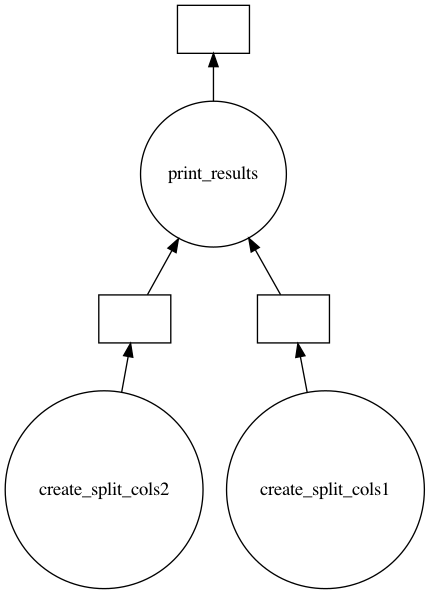

In [12]:
#needed to brew install graphviz
z.visualize()

In [13]:
client.close()